In [1]:
from SYK_fft import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from ConformalAnalytical import *


\begin{align}
    \Sigma(\tau) &= g^2 G(\tau)D(\tau) \\
    \Pi(\tau) &= -2g^2 G(\tau)G(-\tau) \\
    G(\omega_n) &= \frac{1}{i\omega_n + \mu - \Sigma(\omega_n)}\\
    D(\nu_n) &= \frac{1}{\nu_n^2 + r - \Pi(\nu_n)}
\end{align}    



In [2]:
Nbig = int(2**18)
err = 1e-6

beta = 500.
mu = 0.0
g = 1.
#r = 0.0 + 1e-8 * 1j
r = 1e-1
kappa = 1.

omega = (2 * np.arange(Nbig) - Nbig + 1) * np.pi/beta
nu = (2 * np.arange(Nbig) - Nbig ) * np.pi/beta
tau = (np.arange(Nbig) + 1./2) * beta/Nbig

In [3]:
Gfreetau = Freq2TimeF(1./(1j*omega + mu),Nbig,beta)
Dfreetau = Freq2TimeB(1./(nu**2 + r),Nbig,beta)
#Dtau = DfreeImagtau(tau,r,beta)
Gtau = Freq2TimeF(GconfImag(omega,g,beta),Nbig,beta)
Dtau = Freq2TimeB(DconfImag(nu,g,beta),Nbig,beta)
#Gtau = Gfreetau
#Dtau = Dfreetau

itern = 0
diff = 1.
x = 0.5

while(diff>err):
    itern+=1
    diffold = diff
    
    oldGtau = 1.0*Gtau
    oldDtau = 1.0*Dtau
    
    oldGomega = Time2FreqF(oldGtau,Nbig,beta)
    oldDomega = Time2FreqB(oldDtau,Nbig,beta)
    
    Sigmatau = 1.0 * kappa * (g**2) * Dtau * Gtau
    Pitau = 2.0 * g**2 * Gtau * Gtau[::-1] #KMS G(-tau) = -G(beta-tau)
    
    Sigmaomega = Time2FreqF(Sigmatau,Nbig,beta)
    Piomega =  Time2FreqB(Pitau,Nbig,beta)
    
    Gomega = x*(1./(1j*omega + mu - Sigmaomega)) + (1-x)*oldGomega
    Domega = x*(1./(nu**2 + r - Piomega)) + (1-x)*oldDomega
   
    Gtau = Freq2TimeF(Gomega - (1./(1j*omega)),Nbig,beta) - 0.5
    #Dtau = Freq2TimeB(Domega - (1./(nu**2+r)),Nbig,beta) + DfreeImagtau(tau,r,beta)
    Dtau = Freq2TimeB(Domega,Nbig,beta)
    
    diffG = (1.0/Nbig) * np. sqrt(np.sum((np.abs(Gtau-oldGtau))**2))
    diffD = (1.0/Nbig) * np. sqrt(np.sum((np.abs(Dtau-oldDtau))**2))
    diff = np.max([diffG,diffD])
    
    if diff>diffold:
        x/=2


    
print("itern = ",itern," , diff = ", diff)
    

itern =  32  , diff =  8.771532406466563e-07


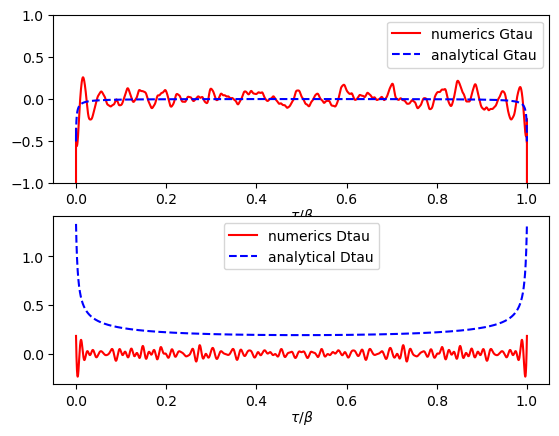

In [4]:
Gconftau = Freq2TimeF(GconfImag(omega,g,beta),Nbig,beta)
Dconftau = Freq2TimeB(DconfImag(nu,g,beta),Nbig,beta)
FreeDtau = DfreeImagtau(tau,r,beta)

fig, ax = plt.subplots(2)

ax[0].plot(tau/beta, np.real(Gtau), 'r', label = 'numerics Gtau')
ax[0].plot(tau/beta, np.real(Gconftau), 'b--', label = 'analytical Gtau' )
ax[0].set_ylim(-1,1)
ax[0].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[0].legend()

ax[1].plot(tau/beta, np.real(Dtau), 'r', label = 'numerics Dtau')
ax[1].plot(tau/beta, np.real(Dconftau), 'b--', label = 'analytical Dtau' )
#ax[1].plot(tau/beta, np.real(FreeDtau), 'g-.', label = 'Free D Dtau' )
#ax[1].set_ylim(0,1)
ax[1].set_xlabel(r'$\tau/\beta$',labelpad = 0)
ax[1].legend()


In [5]:
np.real(Dconftau[Nbig//2]), np.real(Dtau[Nbig//2])

(0.19016972864632442, 0.015092974498226707)

In [ ]:
plt.plot(nu, np.imag(Domega),'p-')
plt.xlim(-1,1)

(-1.0, 1.0)

In [ ]:
omega[Nbig//2 ]

In [ ]:
start, stop = Nbig//2, Nbig-1
startB = Nbig//2 + 1 
delta = 0.420374134464041
conf_fit_G = 3.2 * np.abs(omega/(g**2))**(2*delta - 1)
conf_fit_D = 0.1 * np.abs(nu[startB:]/(g**2))**(1-4*delta)
fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(8)
titlestring = r'$\beta$ = ' + str(beta) + r'     $\log_2{N}$ = ' + str(np.log2(Nbig))
fig.suptitle(titlestring)
fig.tight_layout(pad=2)

ax1.loglog(omega[start:]/(g**2), -np.imag(Gomega[start:])*(g**2),'p')
ax1.loglog(omega[start:]/(g**2), conf_fit_G[start:],'k--')
ax1.set_xlim(5e-3,1)
ax1.set_ylim(5e-1,10)
ax1.set_xlabel(r'$\omega_n/g^2$')
ax1.set_ylabel(r'$-g^2\,\Im{G(\omega_n)}$')
#titlestring1 = r'$\beta$ = ' + str(beta) + r'     $\log_2{N}$ = ' + str(np.log2(Nbig))
#ax1.set_title(titlestring1)

ax2.loglog(nu[startB:]/(g**2), np.real(Domega[startB:])*(g**2),'p')
ax2.loglog(nu[startB:]/(g**2), conf_fit_D,'k--')
ax2.set_xlim(5e-3,10)
ax2.set_ylim(5e-6,10)
ax2.set_xlabel(r'$\nu_n/g^2$')
ax2.set_ylabel(r'$g^2\,\Re{D(\nu_n)}$',labelpad = None)
#titlestring2 = r'$\beta$ = ' + str(beta) + r'     $\log_2{N}$ = ' + str(np.log2(Nbig))
#ax2.set_title(titlestring)



In [ ]:
plt.plot(tau/beta, np.real(Dconftau - Dtau))

In [ ]:
np.allclose(np.imag(Domega),np.zeros_like(Domega))